In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


In [2]:
def read_image(filename):
    image = cv.imread(filename) / 255.0
    height, width = image.shape[:2]
    bounding_box = np.zeros(image.shape)
    bounding_box[90:350, 110:250, :] = 1
    bb_width, bb_height = 140, 260
    background = image[bounding_box == 0].reshape((height * width - bb_width * bb_height, 3))
    foreground = image[bounding_box == 1].reshape((bb_width * bb_height, 3))
   
    return image, foreground, background

In [56]:

class GMM(object):
    def __init__(self, image, foreground, background):
        self.image = image
        self.foreground = foreground
        self.background = background

    def gaussian_scores(self, data, k):
        num_data_points, num_features = data.shape[0], data.shape[1]

        diff = data - self.mu[k]
        inv_covariance = np.linalg.inv(self.cov[k])
        det_covariance = np.linalg.det(self.cov[k])
        
        # Calculate the exponent term of the Gaussian PDF
        exponent = -0.5 * np.sum(np.dot(diff, inv_covariance) * diff, axis=1)
        
        # Calculate the normalization constant
        normalization = 1.0 / (np.sqrt((2 * np.pi) ** num_features * det_covariance))
        
        # Calculate the PDF values
        pdf_values = normalization * np.exp(exponent)
        self.pdf_values = pdf_values
        return pdf_values

    def fit_single_gaussian(self, data):
        self.mu = [np.mean(data, axis=0)]
        self.sigma = np.std(data, axis=0)
        self.cov = np.diag(np.var(data, axis=0))
        self.cov_1 = np.diag(np.var(data, axis=0))
        self.lamb = np.ones(1)


    def estep(self, data):
        num_components = len(self.lamb)
        num_data_points = data.shape[0]
        r = np.zeros((num_data_points, num_components))

        for i in range(num_components):
            # Calculate the posterior probability for each data point and component
            r[:, i] = self.lamb[i] * self.gaussian_scores(data, i)

        # Normalize responsibilities to sum to 1 for each data point
        r /= np.sum(r, axis=1, keepdims=True)
   
        return r


    def mstep(self, data, r):
        num_components = r.shape[1]
        num_data_points = data.shape[0]

        # Update weights
        new_weights = np.mean(r, axis=0)

        # Update means
        new_means = np.dot(r.T, data) / np.sum(r, axis=0, keepdims=True).T

        # Update covariances
        new_covariances = np.zeros((num_components, data.shape[1], data.shape[1]))
        for i in range(num_components):
            diff = data - new_means[i]
            cov = np.dot(r[:, i] * diff.T, diff) / np.sum(r[:, i])
            new_covariances[i] = np.diag(np.diag(cov))  # Diagonal covariance matrices

        return new_weights, new_means, new_covariances

    def em_algorithm(self, data, n_iterations = 10):
        num_data_points, num_features = data.shape
        num_components = len(self.lamb)

        for iteration in range(n_iterations):
            r = self.estep(data)
            self.lamb, self.mu, self.cov = self.mstep(data, r)

    def split(self, epsilon = 0.1):
        mu = []
        cov = []
        lamb = []
        for k in range(len(self.mu)):
            mu_k = self.mu[k]
            sigma_k = self.sigma[k]
            lambda_k = self.lamb[0]
            
            lamb_k_1, lamb_k_2 = lambda_k / 2, lambda_k / 2
            lamb.append(lamb_k_1)
            lamb.append(lamb_k_2)
            
            mu_k_1, mu_k_2 = mu_k + epsilon * sigma_k, mu_k - epsilon * sigma_k
            mu.append(mu_k_1)
            mu.append(mu_k_2)
            
            cov.append(self.cov_1)
            cov.append(self.cov_1)
        
        self.lamb = np.asarray(lamb)
        self.mu = np.asarray(mu)
        self.sigma = np.asarray(2 * list(self.sigma))
        self.cov = np.asarray(cov)

    def probability(self, threshold):
        img_copy = self.image.reshape(-1, self.image.shape[2])
        pr = np.sum([self.gaussian_scores(img_copy, k) for k in range(self.mu.shape[0])], axis=0)
        pr = pr.reshape(self.image.shape[:2]) / pr.max()
        idx = np.where(pr > threshold)
        return idx

    def sample(self, threshold):
        idx = self.probability(threshold)

        img_copy = self.image.copy() * 255
        img_copy = cv.cvtColor(img_copy.astype(np.uint8), cv.COLOR_HSV2BGR)
        img_copy[idx] = np.zeros(3)
        img_copy = cv.cvtColor(img_copy, cv.COLOR_BGR2GRAY)

        return img_copy

    def train(self, data, n_splits, n_iterations):
        self.fit_single_gaussian(data)
        
        for i in range(n_iterations):
            if i < n_splits:
                self.split()
            
            self.em_algorithm(data) 


        
   

In [ ]:

class GMM(object):
    def __init__(self, image, foreground, background):
        self.image = image
        self.foreground = foreground
        self.background = background

    def gaussian_scores(self, data, k):
        num_data_points, num_features = data.shape[0], data.shape[1]

        diff = data - self.mu[k]
        inv_covariance = np.linalg.inv(self.cov[k])
        det_covariance = np.linalg.det(self.cov[k])
        
        # Calculate the exponent term of the Gaussian PDF
        exponent = -0.5 * np.sum(np.dot(diff, inv_covariance) * diff, axis=1)
        
        # Calculate the normalization constant
        normalization = 1.0 / (np.sqrt((2 * np.pi) ** num_features * det_covariance))
        
        # Calculate the PDF values
        pdf_values = normalization * np.exp(exponent)
        self.pdf_values = pdf_values
        return pdf_values

    def fit_single_gaussian(self, data):
        self.mu = [np.mean(data, axis=0)]
        self.sigma = np.std(data, axis=0)
        self.cov = np.diag(np.var(data, axis=0))
        self.cov_1 = np.diag(np.var(data, axis=0))
        self.lamb = np.ones(1)


    def estep(self, data):
        num_components = len(self.lamb)
        num_data_points = data.shape[0]
        r = np.zeros((num_data_points, num_components))

        for i in range(num_components):
            # Calculate the posterior probability for each data point and component
            r[:, i] = self.lamb[i] * self.gaussian_scores(data, i)

        # Normalize responsibilities to sum to 1 for each data point
        r /= np.sum(r, axis=1, keepdims=True)
   
        return r


    def mstep(self, data, r):
        num_components = r.shape[1]
        num_data_points = data.shape[0]

        # Update weights
        new_weights = np.mean(r, axis=0)

        # Update means
        new_means = np.dot(r.T, data) / np.sum(r, axis=0, keepdims=True).T

        # Update covariances
        new_covariances = np.zeros((num_components, data.shape[1], data.shape[1]))
        for i in range(num_components):
            diff = data - new_means[i]
            cov = np.dot(r[:, i] * diff.T, diff) / np.sum(r[:, i])
            new_covariances[i] = np.diag(np.diag(cov))  # Diagonal covariance matrices

        return new_weights, new_means, new_covariances

    def em_algorithm(self, data, n_iterations = 10):
        num_data_points, num_features = data.shape
        num_components = len(self.lamb)

        for iteration in range(n_iterations):
            r = self.estep(data)
            self.lamb, self.mu, self.cov = self.mstep(data, r)

    def split(self, epsilon = 0.1):
        mu = []
        cov = []
        lamb = []
        for k in range(len(self.mu)):
            mu_k = self.mu[k]
            sigma_k = self.sigma[k]
            lambda_k = self.lamb[0]
            
            lamb_k_1, lamb_k_2 = lambda_k / 2, lambda_k / 2
            lamb.append(lamb_k_1)
            lamb.append(lamb_k_2)
            
            mu_k_1, mu_k_2 = mu_k + epsilon * sigma_k, mu_k - epsilon * sigma_k
            mu.append(mu_k_1)
            mu.append(mu_k_2)
            
            cov.append(self.cov_1)
            cov.append(self.cov_1)
        
        self.lamb = np.asarray(lamb)
        self.mu = np.asarray(mu)
        self.sigma = np.asarray(2 * list(self.sigma))
        self.cov = np.asarray(cov)

    def probability(self, threshold):
        img_copy = self.image.reshape(-1, self.image.shape[2])
        pr = np.sum([self.gaussian_scores(img_copy, k) for k in range(self.mu.shape[0])], axis=0)
        pr = pr.reshape(self.image.shape[:2]) / pr.max()
        idx = np.where(pr > threshold)
        return idx

    def sample(self, threshold):
        idx = self.probability(threshold)

        img_copy = self.image.copy() * 255
        img_copy = cv.cvtColor(img_copy.astype(np.uint8), cv.COLOR_HSV2BGR)
        img_copy[idx] = np.zeros(3)
        img_copy = cv.cvtColor(img_copy, cv.COLOR_BGR2GRAY)

        return img_copy

    def train(self, data, n_splits, n_iterations):
        self.fit_single_gaussian(data)
        
        for i in range(n_iterations):
            if i < n_splits:
                self.split()
            
            self.em_algorithm(data) 
    


        
   

In [63]:
image, foreground, background = read_image('data/person.jpg')

gmm_background = GMM(image, foreground, background)
gmm_background.train(background, 3, 10)

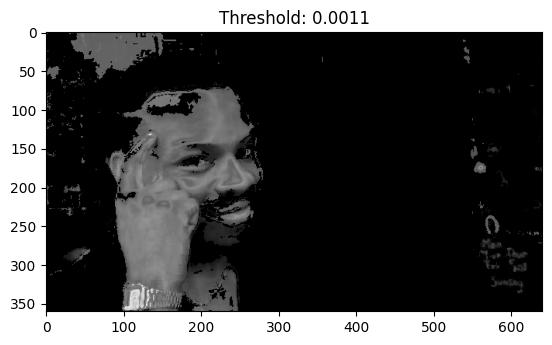

In [64]:
threshold = 0.0011
plt.imshow(gmm_background.sample(threshold), cmap='gray')
plt.title(f'Threshold: {threshold}')
plt.show()